In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Jan 21 22:54:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   32C    P8    23W / 250W |   3564MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   31C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 60

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)

## For iter12, let's try increaseing the learning rate from 1em5 to 1p5em5 as the
## training costs have been dropping almost "linearlY" on the semilog plot
## for several iterations, suggesting that we can afford to take the risk
## For good measure, we'll try this for 10 epochs as a test 
##  Iter12 seems to have worked we4ll, so start iter13 for 60 epochs
## so it will run over night
folder = '21Jan_DDplus_loss_Ba_iter13_floatAll_60epochs_1p5em5_4xwill'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 48 ## batch_size = 24 ---> 4763MiB / 12066MiB on Titan V
# How fast to learn
learning_rate = 1.5e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(2)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

## finished at training cost = 1.46, validation cost = 1.50
##d_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
d_folder = '21Jan_DDplus_loss_Ba_iter12_floatAll_10epochs_1em5_4xwill'
d_name = d_folder
suffix = 'final'
dict_name = 'ML/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)



output =  ML/21Jan_DDplus_loss_Ba_iter13_floatAll_60epochs_1p5em5_4xwill
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28   

<All keys matched successfully>

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                    '/share/lazy/will/data/June30_2020_80k_2.h5',
                                    '/share/lazy/will/data/June30_2020_80k_3.h5',
                                    '/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                          device=device,
##                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,

## For iter12, change slice(18000,None) to slice(10000,None)
## First, we'll see if this changes the validation cost significantly
##  Second, we will see if this reduces the validation cost fluctuations
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
                            slice = slice(10000,None)
                           )


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

nEvts =  80000
len(pocaMx[0]) =  196
len(pocaMx[1]) =  35
len(pocaMx[2]) =  265
len(pocaMx[3]) =  128
len(pocaMx[4]) =  124
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 196
 iEvt, nTrks =  1 35
 iEvt, nTrks =  2 265
 iEvt, nTrks =  3 128
 iEvt, nTrks =  4 124
 iEvt, nTrks =  5 122
 iEvt, nTrks =  6 300
 iEvt, nTrks =  7 179
 iEvt, nTrks =  8 243
 iEvt, nTrks =  9 112
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  -2.440992e-05
majorAxis[iTrk][1][0] =  -0.00038087237
majorAxis[iTrk][2][0] =  0.08211532
minorAxis_1[iTrk][0][0] =  -17.631672
minorAxis_1[iTrk][1][0] =  1.130005
minorAxis_1[iTrk][2][0] =  4.7444193e-08
minorAxis_2[iTrk][0][0] =  1.1299927
minorAxis_2[iTrk][1][0] =  17.631481
minorAxis_2[iTrk][2][0] =  0.08211532
  
majorAxis[iTrk][0][0] =  -0.02277395
majorAxis[iTrk][1][0] =  0.0014473597
majorAxis[iTrk][2][0] =  0.6347583
minorAxis_1[iTrk][0][0] =  -

pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] =  2.8546858
minor

<IPython.core.display.Javascript object>


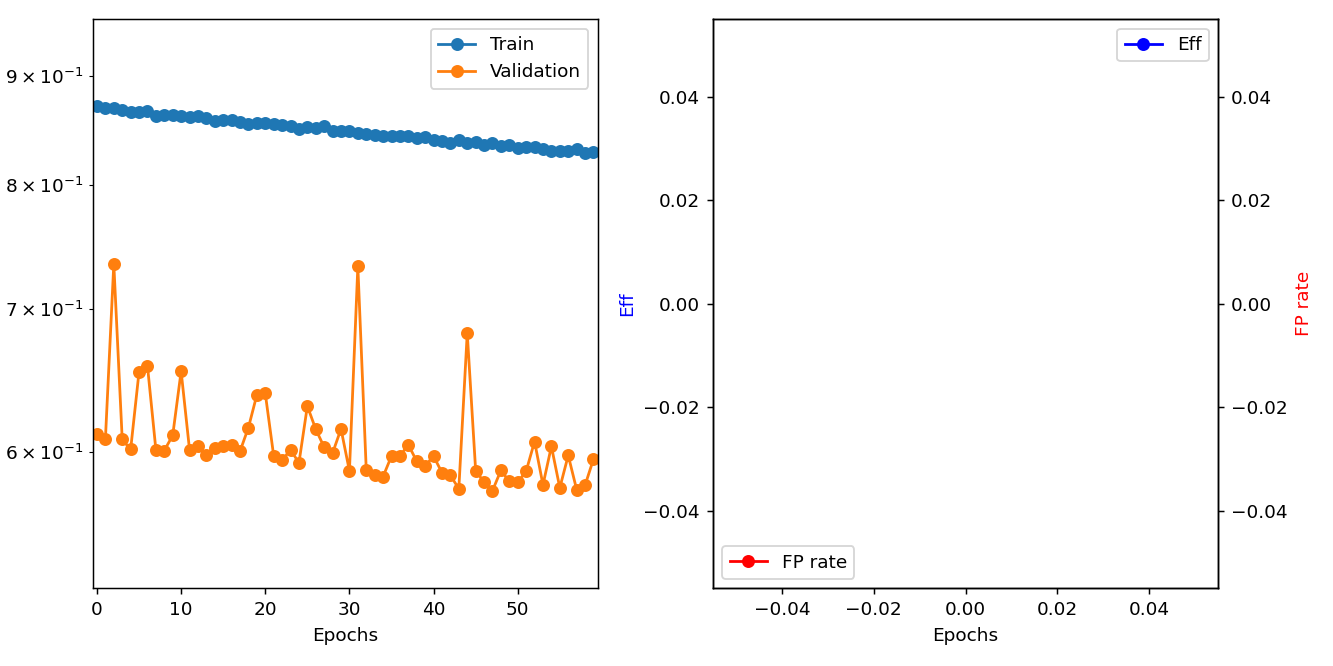

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 6667, val = 209


Number of batches: train = 6667, val = 209


Epoch 0: train=0.871004, val=0.611423, took 601.95 s


Epoch 1: train=0.869725, val=0.607996, took 600.69 s


Epoch 2: train=0.869685, val=0.734642, took 603.06 s


Epoch 3: train=0.867733, val=0.60792, took 600.39 s


Epoch 4: train=0.866063, val=0.601363, took 601.48 s


Epoch 5: train=0.865482, val=0.653998, took 600.11 s


Epoch 6: train=0.866331, val=0.658213, took 601.53 s


Epoch 7: train=0.862058, val=0.601227, took 600.27 s


Epoch 8: train=0.862939, val=0.600687, took 601.12 s


Epoch 9: train=0.862638, val=0.610573, took 600.02 s


Epoch 10: train=0.862178, val=0.654352, took 600.36 s


Epoch 11: train=0.861362, val=0.601158, took 602.12 s


Epoch 12: train=0.862166, val=0.603611, took 599.36 s


Epoch 13: train=0.860205, val=0.597498, took 599.57 s


Epoch 14: train=0.857539, val=0.602511, took 599.51 s


Epoch 15: train=0.85796, val=0.603361, took 600.51 s


Epoch 16: train=0.858054, val=0.60402, took 599.18 s


Epoch 17: train=0.856298, val=0.60025, took 598.87 s


Epoch 18: train=0.854779, val=0.615794, took 599.2 s


Epoch 19: train=0.855172, val=0.637882, took 600.0 s


Epoch 20: train=0.855622, val=0.638872, took 599.23 s


Epoch 21: train=0.854215, val=0.597191, took 599.62 s


Epoch 22: train=0.853281, val=0.594302, took 599.92 s


Epoch 23: train=0.853093, val=0.601297, took 600.46 s


Epoch 24: train=0.84998, val=0.592682, took 599.06 s


Epoch 25: train=0.851577, val=0.630173, took 599.43 s


Epoch 26: train=0.850476, val=0.614637, took 603.05 s


Epoch 27: train=0.852243, val=0.602844, took 601.81 s


Epoch 28: train=0.848506, val=0.599111, took 599.38 s


Epoch 29: train=0.847823, val=0.614833, took 598.81 s


Epoch 30: train=0.847828, val=0.587598, took 599.31 s


Epoch 31: train=0.846411, val=0.73273, took 598.22 s


Epoch 32: train=0.845765, val=0.588251, took 603.02 s


Epoch 33: train=0.844685, val=0.584858, took 598.7 s


Epoch 34: train=0.843768, val=0.584073, took 599.04 s


Epoch 35: train=0.843311, val=0.597108, took 599.67 s


Epoch 36: train=0.843287, val=0.597209, took 597.12 s


Epoch 37: train=0.843574, val=0.604449, took 598.61 s


Epoch 38: train=0.841834, val=0.593759, took 597.99 s


Epoch 39: train=0.842932, val=0.590917, took 599.77 s


Epoch 40: train=0.840131, val=0.597052, took 597.41 s


Epoch 41: train=0.838872, val=0.586465, took 597.91 s


Epoch 42: train=0.837579, val=0.584717, took 598.73 s


Epoch 43: train=0.839592, val=0.576442, took 597.3 s


Epoch 44: train=0.836968, val=0.68182, took 598.32 s


Epoch 45: train=0.838407, val=0.587841, took 598.48 s


Epoch 46: train=0.835142, val=0.580486, took 598.78 s


Epoch 47: train=0.837298, val=0.575209, took 597.75 s


Epoch 48: train=0.834456, val=0.587963, took 597.91 s


Epoch 49: train=0.834975, val=0.580955, took 598.64 s


Epoch 50: train=0.833057, val=0.58045, took 598.4 s


Epoch 51: train=0.83387, val=0.587461, took 598.51 s


Epoch 52: train=0.833901, val=0.606567, took 597.88 s


Epoch 53: train=0.831942, val=0.578808, took 598.29 s


Epoch 54: train=0.830311, val=0.603402, took 597.92 s


Epoch 55: train=0.830277, val=0.576988, took 597.49 s


Epoch 56: train=0.82995, val=0.597516, took 598.19 s


Epoch 57: train=0.831358, val=0.575895, took 597.42 s


Epoch 58: train=0.827897, val=0.57858, took 597.33 s


Epoch 59: train=0.829201, val=0.59511, took 598.72 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


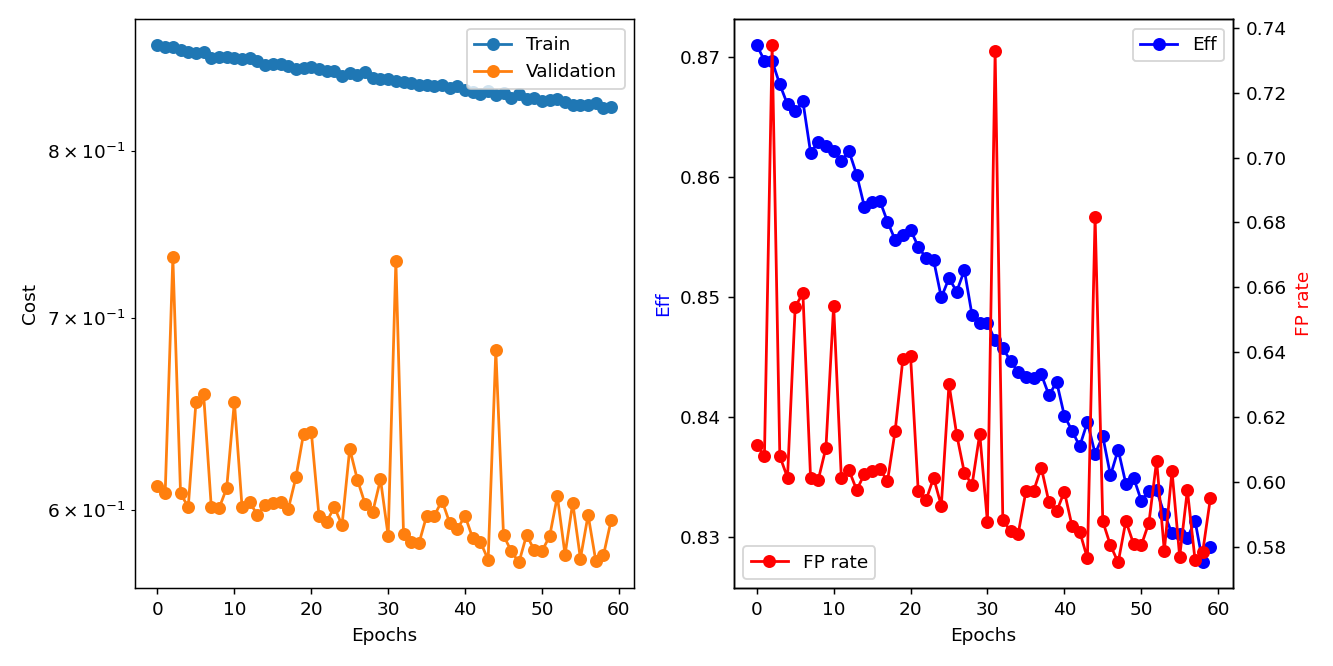

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [22]:
##quit()